# EEG Demo

### some note here to explain that data is not open yet

## Stimuli

https://naturalscenesdataset.org

(downsampled) examples:

![sample1](demo_eeg_data/shared0140_nsd11797.png)
![sample2](demo_eeg_data/shared0936_nsd67830.png)
![sample3](demo_eeg_data/shared0944_nsd68742.png)

## imports

install mne

In [7]:
%matplotlib inline
from os.path import join, expanduser, basename
import glob, json
import numpy, tqdm, mne, pandas
import rsatoolbox
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
mne.set_log_level(verbose='error')
demo_dir = './demo_eeg_data/'
raw_dir = expanduser('~/data/imasem/rawdata')
deriv_dir = expanduser('~/data/imasemrsa/epochs')

## Preprocess data

Here we preprocess the EEG data, by looping over the runs, 
reading in the bdf raw data file, applying a band pass filter,
setting a new reference (from electrodes on the mastoids) and epoching
the trials.

In [2]:


fpaths = glob.glob(join(raw_dir, '**/*_eeg.bdf'), recursive=True)
all_epochs = []
for fpath in tqdm.tqdm(fpaths, smoothing=0):
    raw = mne.io.read_raw_bdf(fpath, preload=True)
    chans_fpath = fpath.replace('_eeg.bdf', '_channels.tsv')
    chans_df = pandas.read_csv(chans_fpath, sep='\t')

    # drop unused channels
    misc_chans = chans_df[chans_df.type=='MISC'].name.to_list()
    raw = raw.drop_channels(misc_chans)

    # filter
    raw = raw.filter(l_freq=0.1, h_freq=40)

    # rereference
    ref_chans = chans_df[chans_df.type=='REF'].name.to_list()
    raw.set_eeg_reference(ref_channels=ref_chans)

    # TODO: add nsd labels in event dict?
    events = mne.find_events(raw)
    eeg_chans = chans_df[chans_df.type=='EEG'].name.to_list()
    epochs = mne.Epochs(
        raw,
        events,
        decim=8,
        tmin=-0.2,
        tmax=+1.0,
        picks=eeg_chans,
        verbose='error'
    )
    fname = basename(fpath.replace('_eeg.bdf', '_epo.fif'))
    epochs.save(join(deriv_dir, fname))
    all_epochs.append(epochs)

0it [00:00, ?it/s]


## Event-Related Potential
To give you an idea of what the data looks like at this point, here's an ERP plot

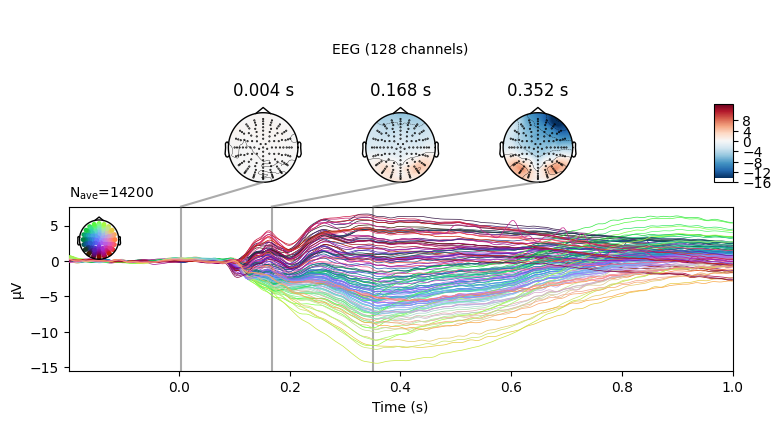

In [8]:
epoch_fpaths = glob.glob(join(deriv_dir, '*_epo.fif'))
all_epochs = [mne.read_epochs(fpath) for fpath in epoch_fpaths]
grand_avg = mne.concatenate_epochs(all_epochs).average()
grand_avg.set_montage(mne.channels.make_standard_montage('biosemi128'))
grand_avg.plot_joint()
pyplot.close()

## Importing the data to rsatoolbox

This is where the rsatoolbox library comes into play.
We use the rsatoolbox function `io.mne.read_epochs` to load each individual run,
then merge them into one large `TemporalDataset` object:

In [25]:
from rsatoolbox.io.mne import read_epochs
from rsatoolbox.data.ops import merge_datasets

fpaths = glob.glob(join(deriv_dir, f'*task-images*.fif'))

dataset = merge_datasets([read_epochs(f) for f in fpaths])


It has an internal structure of *trials x channels x samples*:

In [26]:
dataset.measurements.shape

(8000, 128, 308)

This `TemporalDataset` object keeps all descriptors that `read_epochs` created for the individual runs:

In [29]:
dataset.obs_descriptors

{'event': array([172, 180, 185, ..., 174, 148, 132], dtype=int32),
 'run': array(['11', '11', '11', ..., '14', '14', '14'], dtype='<U2'),
 'filename': array(['sub-07_ses-03_task-images_run-11_epo.fif',
        'sub-07_ses-03_task-images_run-11_epo.fif',
        'sub-07_ses-03_task-images_run-11_epo.fif', ...,
        'sub-05_ses-04_task-images_run-14_epo.fif',
        'sub-05_ses-04_task-images_run-14_epo.fif',
        'sub-05_ses-04_task-images_run-14_epo.fif'], dtype='<U40'),
 'sub': array(['07', '07', '07', ..., '05', '05', '05'], dtype='<U2')}

We will add one **observation descriptor**, which defines the structure of the data for crossvalidation. In this case we'll say that we will fold across every 3 runs. We use Python's floor division operator `//` such that runs 1-3 will be assigned to fold 0, 4-6 to fold 1, and so on.

In [33]:
RUNS_PER_FOLD = 3
folds = dataset.obs_descriptors['run'].astype(int) // RUNS_PER_FOLD
dataset.obs_descriptors['fold'] = folds
numpy.unique(folds)

array([0, 1, 2, 3, 4, 5])

### Spatiotemporal window

For the first hypothesis, we will look at a spatiotemporal window. In other words, we will consider both channels and timepoints in the window to be features of the representational patterns. First, let's select only the first 600ms:

In [35]:
dataset_window = dataset.subset_time('time', .0, .600)

Then we collapse the time dimension, to create a regular `Dataset` object where the samples are represented as *channels* (or features).

In [36]:
dataset_window_flat = dataset_window.time_as_channels()
dataset_window_flat.measurements.shape

(8000, 19712)

## Calculate data RDMs

We will create one RDM for per subject, so that later we can test our hypothesis on the sample.
This splits the dataset into a list of `Dataset` objects:

In [37]:
subject_datasets = dataset_window_flat.split_obs(by='sub')
len(subject_datasets)

6

Then pass this list to `calc_rdm_crossnobis` to compute the crossvalidated mahalanobis or crossnobis dissimilarity:

In [39]:
from rsatoolbox.rdm.calc import calc_rdm
data_rdms = calc_rdm(subject_datasets, method='crossnobis', descriptor='event', cv_descriptor='fold')

plot rdms below
Talk about RDMs here, lack of structure due to scenes, order.

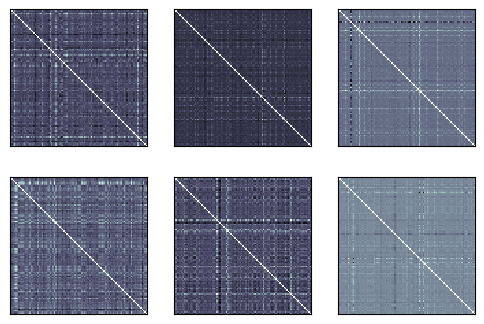

In [43]:
fig, _, _ = rsatoolbox.vis.show_rdm(data_rdms)
pyplot.show()

## Annotations

For the purpose of this demo we asked two participants to annotate the stimuli. They each viewed the 100 scene images one by one in a [Meadows "Stimulus Form" task](https://meadows-research.com). They rated the distance of the most prominent item, the presence of animate beings, whether the scene is out- or indoors, and the dominant color.

![example of annotation interface on Meadows](demo_eeg_data/annotate.png)

### Preprocess the annotation data

Here we read each of the two participants' data files, recode some of the values, and keep them as Pandas Dataframe objects.

In [ ]:
fpaths = glob(join(data_dir, '*_annotations.csv'))
subject_dfs = []
for fpath in fpaths:
    df_raw = pandas.read_csv(fpath)
    df = pandas.json_normalize(df_raw.label.apply(json.loads).tolist())
    df['sub'] = basename(fpath).split('_')[-3]
    df['nsd'] = df_raw.stim1_name
    df['animacy'] = df.animacy.str.contains('Yes').astype(float)
    df['in_out'] = df.inoutdoors.str.contains('Indoor').astype(float)
    df['r'] = (df.color == 'red').astype(float)
    df['g'] = (df.color == 'green').astype(float)
    df['b'] = (df.color == 'blue').astype(float)
    dist_unscaled = df.distance.astype(float).values.reshape(-1, 1)
    df['distance'] = MinMaxScaler().fit_transform(dist_unscaled).squeeze()
    df = df.drop(['inoutdoors', 'color'], axis=1)
    subject_dfs.append(df)

subject_dfs[0].sample(7)

,distance,animacy,inoutdoors,color,indoor,stim
92,0.84,True,Outdoor,green,False,shared0318_nsd25112
97,0.69,True,Outdoor,green,False,shared0008_nsd03172
86,0.49,True,Outdoor,red,False,shared0968_nsd70194
99,0.21,True,Outdoor,blue,False,shared0925_nsd66977
44,0.58,False,Outdoor,green,False,shared0857_nsd62210
5,0.14,False,Indoor,red,True,shared0789_nsd56912
56,0.62,True,Outdoor,green,False,shared0589_nsd43690


### Calulcate Annotation RDMs

Then we make RDMs for each of the features annotated.

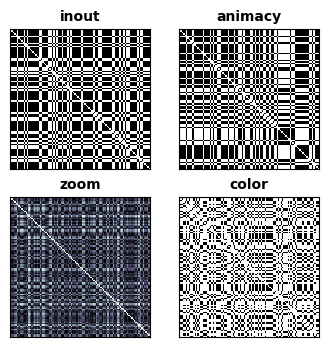

In [ ]:

ds = Dataset.from_df(pandas.concat(subject_dfs))

rdm_list = []
for c in ('animacy', 'in_out', 'distance'):
    model_rdm = calc_rdm_euclidean(
        ds.subset_channel('name', c),
        descriptor='nsd'
    )
    model_rdm.rdm_descriptors['name'] = [c]
    rdm_list.append(model_rdm)
model_rdm = calc_rdm_euclidean(
    ds.subset_channel('name', ['r', 'g', 'b']),
    descriptor='nsd'
)
model_rdm.rdm_descriptors['name'] = ['color']
rdm_list.append(model_rdm)
rdms = concat(rdm_list)
rdms.dissimilarities = numpy.sqrt(rdms.dissimilarities)
fig, _, _ = rsatoolbox.vis.show_rdm(model_rdms, rdm_descriptor='name')
pyplot.show()

## Create rsa models

In [ ]:
model_names = annotation_rdms.rdm_descriptors['name']
models = []
for model_name in model_names:
    model_rdm = annotation_rdms.subset('name', model_name)
    models.append(ModelFixed(model_name, model_rdm))


## Evaluate models

In [ ]:

# Fixed
result_fixed = eval_fixed(models, rdms_condition, method='corr')
print(result_fixed)
plt.close('all')
plt.figure()
fig, _, _ = plot_model_comparison(result_fixed)
plt.savefig(join(plot_path, f'model-comp-fixed_task-{task}_phase-{phase}.png'), dpi=300)
